In [248]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os
from tensorflow.keras.models import model_from_json
import scipy.signal
import math as m
import ast
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
from wordSeg import preprocess,lineSegment,wordSegment,unshear
from s_extract import check_extraction,delete_line
from word_corect import answers
def implt(img, cmp=None, t=''):
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()
    
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


alph="ACDEFGHILMNOQRSTUVXZ"
dic={}
for i,ch in enumerate(alph):
    dic[i]=ch

Loaded model from disk


In [249]:
def vertical_projection(thresh):
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    hist=sumCols
    hist=(hist - np.amin(hist))/(np.amax(hist) - np.amin(hist))
    return hist # retourne le nombre de pixels blancs de chaque colonne de l'image binarisée


def fix_hist(hist,seuil):
    hist_=[]
    for i in range(len(hist)):
        if hist[i]<=seuil:
            hist_.append(0)
        else:
            b=hist[i]
            hist_.append(b)
    return hist_

def find_indexe(s):
    index=[]
    i=0
    while i<=len(s)-1:
        cnt_0=0
        j=0
        #if i==0 and s[i]==0:
            #index.append(cnt_0)
            #i+=1
            
        if s[i]!=0 and i<=len(s)-1:
            i+=1
        else:
            j=i-1
            while s[i]==0 and i<=len(s)-1:
                if i==len(s)-1:
                    cnt_0+=1
                    i+=1
                    break
                else:
                    cnt_0+=1
                    i+=1
            index.append(m.ceil(cnt_0/2)+j)
                
                
    return index
        

def plot_histogram(thresh,hist,indexes):
    h, w = thresh.shape
    RGBmask = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)+255 # création de fond blanc
    count=0
    for l in hist:
        cv2.line(RGBmask, (count, int(h*(l))), (count, h), color=[0,255,0], thickness=1)
        count += 1

    for i in indexes:
        cv2.circle(RGBmask, (i, int(h*hist[i])), radius=2, color=[255,0,0], thickness=-1) 
        #cv2.line(RGBmask, (i, 0), (i, h), color=[255,0,0],#thickness=1)
    implt(thresh,'gray', 'Binary OTSU + (Filter + TO_ZERO)')
    implt(RGBmask, cmp='gray', t='Final')


In [250]:
def clean(img):
    from skimage import util

    #img = cv2.imread(r"im.png")
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # Use cv2.CCOMP for two level hierarchy
    # create an empty mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for i, cnt in enumerate(contours):
        if hierarchy[0][i][3] != -1: # basically look for holes
            # if the size of the contour is less than a threshold (noise)
            if cv2.contourArea(cnt) < 55:
                # Fill the holes in the original image
                cv2.drawContours(img, [cnt], 0,(255,255,255), -1)
    image = cv2.bitwise_not(img, img, mask=mask)
    return image
def bilateral_norm(img):
    img = cv2.bilateralFilter(img, 9, 15, 30)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
def histogram_norm(img):
    img = bilateral_norm(img)
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # Filtrage en image dont les pixels de premier plan sont blancs
    img = 255 - img #filtrage en noir 
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255  # normalisation      
    hist, bins = np.histogram(img.ravel(), 256, [0,256]) # img.ravel pour transformer l'image en un vecteur
                                                         #  
    img = img.astype(np.uint8) # 

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)
def cropp(img):
    h,w = img.shape
    top=0
    down=0
    left=0
    right=0
    
    halt = False
    for i in range(h):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                top = i-1
                break
                
    halt = False
    for i in reversed(range(h)):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                down = i+1
                break
    
    halt = False
    for i in range(w):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                left = i-1
                break
                
    halt = False
    for i in reversed(range(w)):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                right = i+1
                break
                
    if (top < 0): top = 0
    if (down < 0): down = 0
    if (left < 0): left = 0
    if (right < 0): right = 0
        
    #print('Top: ', top)
    #print('Down: ', down)
    #print('Left: ', left)
    #print('Right: ', right)
    
    return img[top:down, left:right]
def segment(img, indexes):
    width=img.shape[1]
    height=img.shape[0]
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    print("svee: ", indexes)
    first = 0
    second = 1
    while (first < len(indexes)) and (second < len(indexes)):
        width = indexes[second] - indexes[first]
        if width <42: # paramètre de réglage
            second += 1
            continue
        roi = img[0:height, indexes[first]:indexes[first]+width]
        roi=cv2.resize(roi,(28,28))
        rois.append(roi)
        first = second
        second += 1
    plt.figure(figsize=(16, 16))
    for i in range(len(rois)):
        ax = plt.subplot(1, len(rois), i+1)
        plt.imshow(rois[i], cmap='binary')
        plt.title(i, fontdict={'fontsize': 15, 'color': 'black'})
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    return rois
        


def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = 255-histogram_norm(img) 
    thresh = cropp(thresh)
    return thresh
import statistics as st
def binary_graph(thresh):
    # Binary graph
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    hist=np.zeros(len(sumCols))
    #mpx=np.maximum(np.min(np.nonzero(sumCols)),30)
    mpx=np.mean(sumCols)
    print(mpx)
    for pix in range(len(sumCols)):
        if sumCols[pix]>mpx:
            hist[pix]=1
        else:
            hist[pix]=0
    return hist
def binary_index(hist):
    # Find index
    import math as m
    indexes=find_indexe(hist)
    #print('index',ind)
    return indexes

def count_pixel(thresh):
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    return sumCols # retourne le nombre de pixels blancs de chaque colonne de l'image binarisée

def plot_hist(thresh,hist):
    plt.plot(np.arange(thresh.shape[1]),vertical_projection(thresh))
    plt.plot(np.arange(thresh.shape[1]),hist)
    return 0
def peack_width(indexes):
    W=[]
    for i in range(len(indexes)-1):
        W.append(indexes[i+1]-indexes[i])
    return W


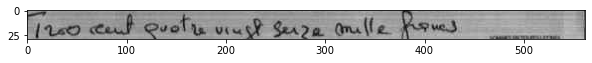

In [279]:
img=cv2.imread(r"C:/Users/Obertys/Desktop/OCR_cheques/cheques/cheque38.jpg")
im=check_extraction(img)[1]
cv2.imwrite('mont.png',im)
implt(im)

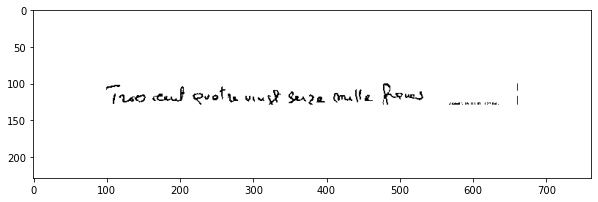

In [280]:
path="mont.png"
img=preprocess(path)


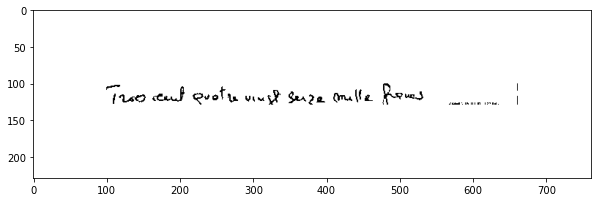

In [281]:
#img=clean(img)
implt(img,'gray')

In [282]:
textLines=lineSegment(img)

imgList=wordSegment(textLines)


No. of Lines 1
No. of Words 7


In [283]:
word=imgList[2]
thresh=preprocessing(word)

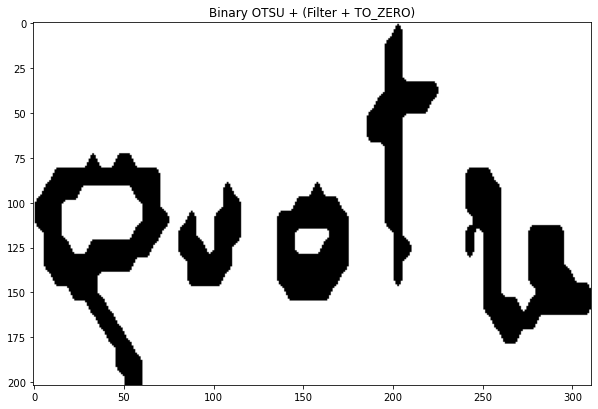

In [284]:
implt(thresh,'gray', 'Binary OTSU + (Filter + TO_ZERO)')

In [285]:
def segment1(img, indexes):
    print(peack_width(indexes))
    pw=int(np.mean(peack_width(indexes)))
    print('min',int(np.min(peack_width(indexes))))
    print('mean',pw)
    print('max',int(np.max(peack_width(indexes))))
    width=img.shape[1]
    height=img.shape[0]
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    print("svee: ", indexes)
    first = 0
    second = 1
    while (first < len(indexes)) and (second < len(indexes)):
        width = indexes[second] - indexes[first]
        if width <=pw: # paramètre de réglage
            second += 1
            continue
        roi = img[0:height, indexes[first]:indexes[first]+width]
        rois.append(roi)
        first = second
        second += 1
    plt.figure(figsize=(16, 16))
    for i in range(len(rois)):
        if rois[i].shape[1]>10:
            rois[i]=cv2.resize(rois[i],(28,28))
            ax = plt.subplot(1, len(rois), i+1)
            plt.imshow(rois[i], cmap='binary')
            plt.title(i, fontdict={'fontsize': 15, 'color': 'black'})
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    return rois 

In [286]:
def plot_histogram(thresh,hist,indexes):
    h, w = thresh.shape
    RGBmask = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)+255 # création de fond blanc
    count=0
    for l in hist:
        cv2.line(RGBmask, (count, int(h*(l))), (count, h), color=[0,255,0], thickness=1)
        count += 1

    for i in indexes:
        cv2.circle(RGBmask, (i, int(h*hist[i])), radius=2, color=[255,0,0], thickness=-1) 
        #cv2.line(RGBmask, (i, 0), (i, h), color=[255,0,0],#thickness=1)
    implt(thresh,'gray', 'Binary OTSU + (Filter + TO_ZERO)')
    implt(RGBmask, cmp='gray', t='Final')

35.40192926045016


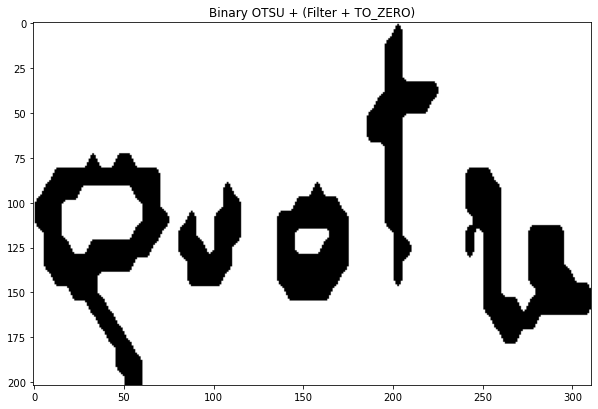

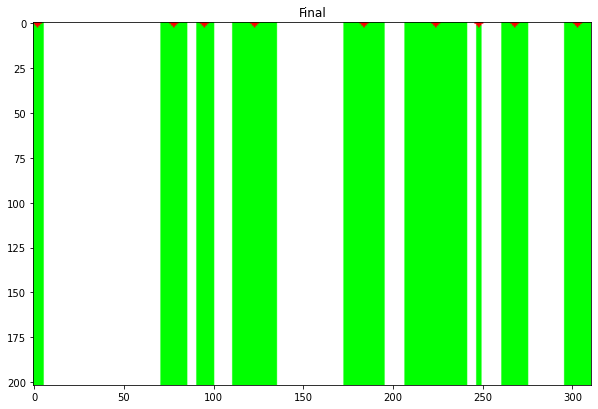

In [287]:
b=binary_graph(thresh)

f=binary_index(b)


plot_histogram(thresh,b,f)

[76, 17, 28, 61, 40, 24, 20, 35]
min 17
mean 37
max 76
svee:  [  0   2  78  95 123 184 224 248 268 303 310]


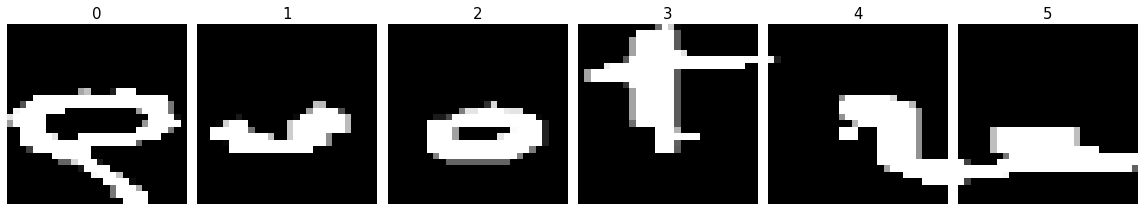

In [288]:
s=segment1(thresh,f)

In [289]:
def recognition(chars):
    words=[]
    for char in chars:
        char=255-char
        img=char.reshape(1,28*28)
        pred=loaded_model.predict_classes(img)
        words.append(dic[int(pred)])
    word="".join(words)
    print(word)
    print(answers(word))

In [290]:
recognition(s)

RUETRE
QUATRE


In [275]:
n=np.random.randint(3000)
cv2.imwrite(r'C:\Users\Obertys\Pictures\charactere\{}.png'.format(n),s[2])

True